Compute the CPT for the FEV1, Unblocked FEV1, % Airway Blockage factor function

We'll apply what we've learned in uniform_x_uniform.ipynb to compute the CPT for the factor function which is the joint probability density function $f_{FEV_1}(Unblocked\ FEV1, \%Small\ Airway\ Blockage)$ 

In [1]:
import numpy as np
import pandas as pd

In [144]:
# Let Unblocked FEV1 be a continuous random variable following a uniform distribution between 2 and 6
def get_unblocked_fev1():
    return np.random.uniform(2, 6)

# Let % Small Airway blockage be a continuous randome variable following a uniform distribution between 0.00 and 1.00
def get_small_airway_blockage():
    return np.random.uniform(0, 100)/100

# Let FEV1 be the product of Unblocked FEV1 and (1 - % Small Airway blockage)
# FEV1 is a continuous random variable following a uniform distribution between 0 and 6
def get_fev1():
    unblocked_fev1 = get_unblocked_fev1()
    small_airway_blockage = get_small_airway_blockage()
    # 0% Small Airway blockage implies that FEV1 = Unblocked FEV1
    # 100% Small Airway blockage implies that FEV1 = 0
    fev1 = unblocked_fev1 * (1 - small_airway_blockage)
    return pd.DataFrame({
        "Unblocked FEV1": [unblocked_fev1], 
        "Small airway blockage": [small_airway_blockage], 
        "FEV1": [fev1]
    })

# We can generate a sample of FEV1 values and put the results in a dataframe
def generate_fev1_sample(n):
    df = get_fev1()
    for _ in range(n):
        df = pd.concat([df, get_fev1()])
    return df

In [145]:
generate_fev1_sample(10)

,Unblocked FEV1,Small airway blockage,FEV1
0,3.044355,0.717456,0.860165
0,3.445436,0.950302,0.171230
0,2.608716,0.557397,1.154625
0,3.185013,0.641246,1.142637
0,4.859494,0.617545,1.858539
0,5.314679,0.754805,1.303133
0,5.269606,0.330455,3.528239
0,2.880195,0.589258,1.183017
0,4.406397,0.011810,4.354359
0,5.829555,0.065646,5.446868


The function `generate_fev1_sample()` can be used to get an estimate of the joint probability distribution of Unblocked FEV1 and % Small Airway blockage, which is also the PDF of FEV1.

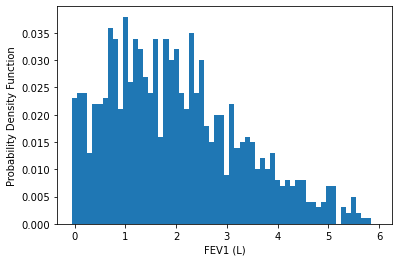

In [147]:
fev1_sample = generate_fev1_sample(1000)["FEV1"]
# Histogram up the sample values into bins of 0.1 units between 0 and 6
hist, bins = np.histogram(fev1_sample, bins=np.arange(0, 6.1, 0.1))
# Normalize the histogram to get the probability of each bin of FEV1
hist_norm = hist / len(fev1_sample)
# Plot the histogram
import matplotlib.pyplot as plt
plt.bar(bins[:-1], hist_norm, width=0.1)
# Set y label to Probability Density Function, set x label to FEV1 (L)
plt.ylabel("Probability Density Function")
plt.xlabel("FEV1 (L)")
plt.show()

Compute the Conditional Probability Table

Since we don't know how to do inference on continuous probability distributions, we need discretize the above model and compute the CPT.

Here's how to discretise the model by sampling
1. Define bins for each variable
2. Add up the bin to which the variable corresponds to
3. Group by the same set of inputs, and outputs and count the number of occurences of each groups
4. Normalize by the total amount of occurences. 

The CPT has three dimensions. For each possible set of bins, it will associate a probability.

Knowing that $P(x \in FEV_1\ bin) = \frac{\#FEV_1\ bin\ outcomes}{\#outcomes}$, we can agglomerate the sample values into bins (i.e. histogram up) and use the bin counts to estimate the CPT of FEV1, Unblocked FEV1, and % Small Airway blockage

In [159]:
# Given a value and an array of bins, this returns the bin that the value falls into
def get_bin_for_value(value, bins):
  hist, bins = np.histogram(value, bins=bins)
  if (value == bins[-1]): 
    return "not allowed"

  idx = np.where(hist == 1)[0].item()
  lower_idx = bins[idx].item()
  upper_idx = bins[idx+1].item()
  return "[{}; {}[".format(lower_idx, upper_idx)

In [183]:
df_binned_sampled = generate_fev1_sample(100000)

bins_unblocked_fev1 = [x/10 for x in range(2, 60+1)]
bins_small_airway_blockage = [x/10 for x in range(0, 10+1)]
bins_fev1 = [x/10 for x in range(0, 60+1)] 

df_binned_sampled["Unblocked FEV1 bin"] = df_binned_sampled["Unblocked FEV1"].apply(lambda x: get_bin_for_value(x, bins_unblocked_fev1))
df_binned_sampled["Small airway blockage bin"] = df_binned_sampled["Small airway blockage"].apply(lambda x: get_bin_for_value(x, bins_small_airway_blockage))
df_binned_sampled["FEV1 bin"] = df_binned_sampled["FEV1"].apply(lambda x: get_bin_for_value(x, bins_fev1))

In [184]:
df_cpt = df_binned_sampled.groupby(["Unblocked FEV1 bin", "Small airway blockage bin", "FEV1 bin"]).size().reset_index(name="count")
df_cpt["p"] = df_cpt.apply(lambda x: x["count"] / len(df_binned_sampled), axis=1)

In [186]:
df_cpt

,Unblocked FEV1 bin,Small airway blockage bin,FEV1 bin,count,p
0,[2.0; 2.1[,[0.0; 0.1[,[1.8; 1.9[,70,0.00070
1,[2.0; 2.1[,[0.0; 0.1[,[1.9; 2.0[,118,0.00118
2,[2.0; 2.1[,[0.0; 0.1[,[2.0; 2.1[,64,0.00064
3,[2.0; 2.1[,[0.1; 0.2[,[1.6; 1.7[,75,0.00075
4,[2.0; 2.1[,[0.1; 0.2[,[1.7; 1.8[,117,0.00117
...,...,...,...,...,...
2066,[5.9; 6.0[,[0.9; 1.0[,[0.1; 0.2[,42,0.00042
2067,[5.9; 6.0[,[0.9; 1.0[,[0.2; 0.3[,57,0.00057
2068,[5.9; 6.0[,[0.9; 1.0[,[0.3; 0.4[,49,0.00049
2069,[5.9; 6.0[,[0.9; 1.0[,[0.4; 0.5[,33,0.00033
